# Tutorial 2 : Neural Processes - 1D GP Data

Last Update : 11 June 2019

**Aim**: 
- Training a simple [Neural Process]
- See how well a NP "learns" a GP kernel

**Nota Bene:**
- Much more details about the framework and dataset can be found in [Tutorial 1 - Conditional Neural Process].
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.


[Neural Process]: https://arxiv.org/abs/1807.01622
[Conditional Neural Process]: https://arxiv.org/pdf/1807.01613.pdf
[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Image Transformer]: https://arxiv.org/abs/1802.05751
[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb
[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb
[Tutorial 3 - Attentive Neural Process]: Tutorial%203%20-%20Attentive%20Neural%20Process.ipynb

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [5]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

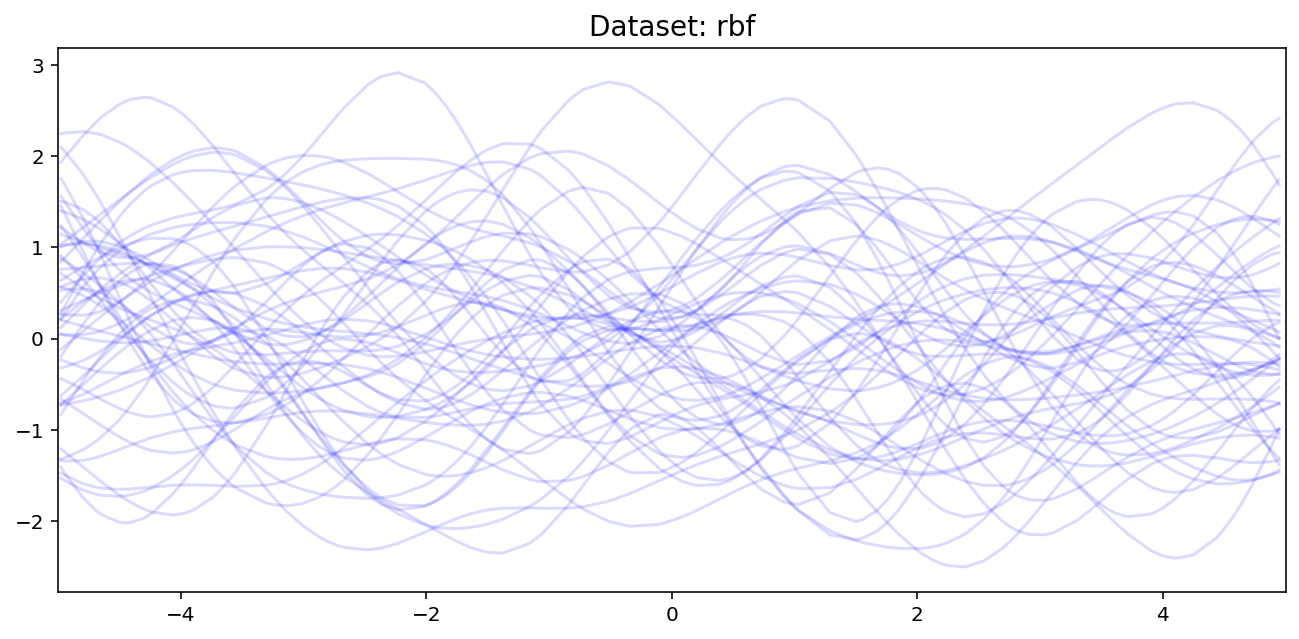

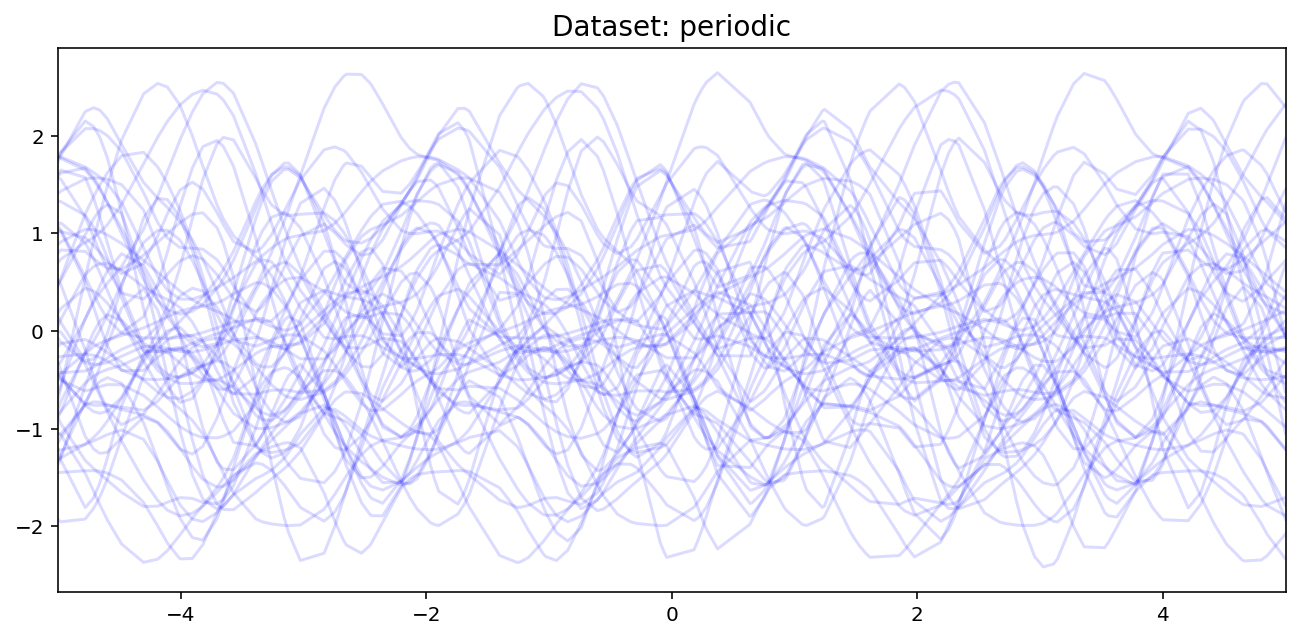

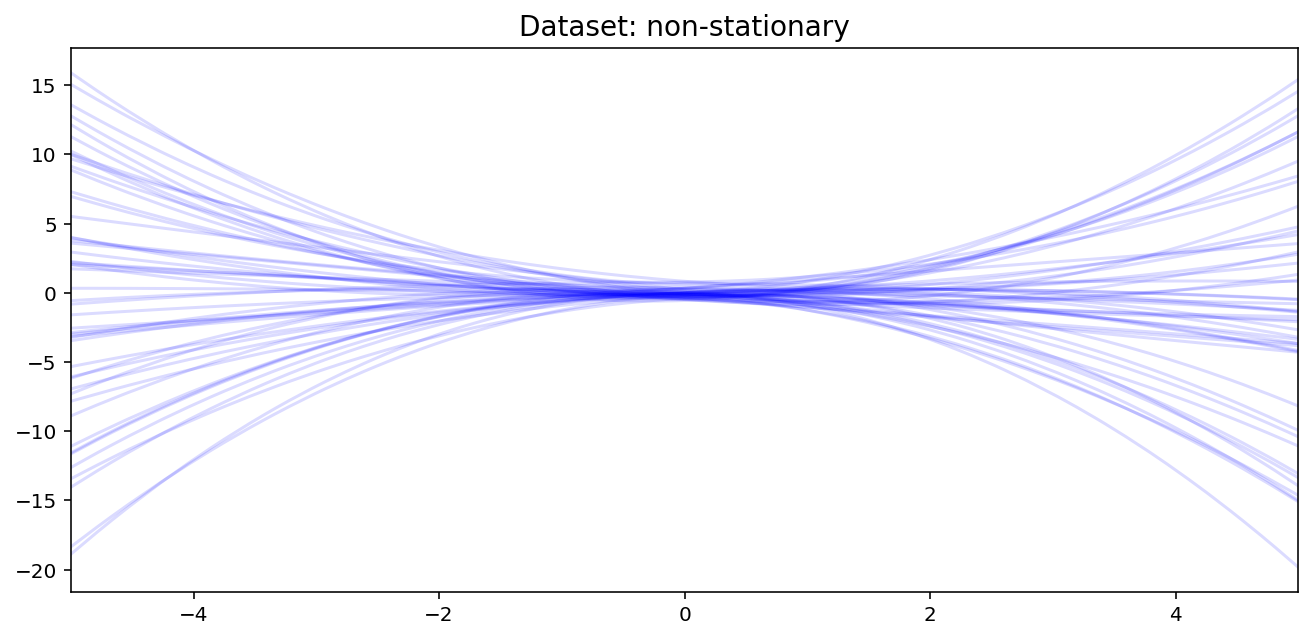

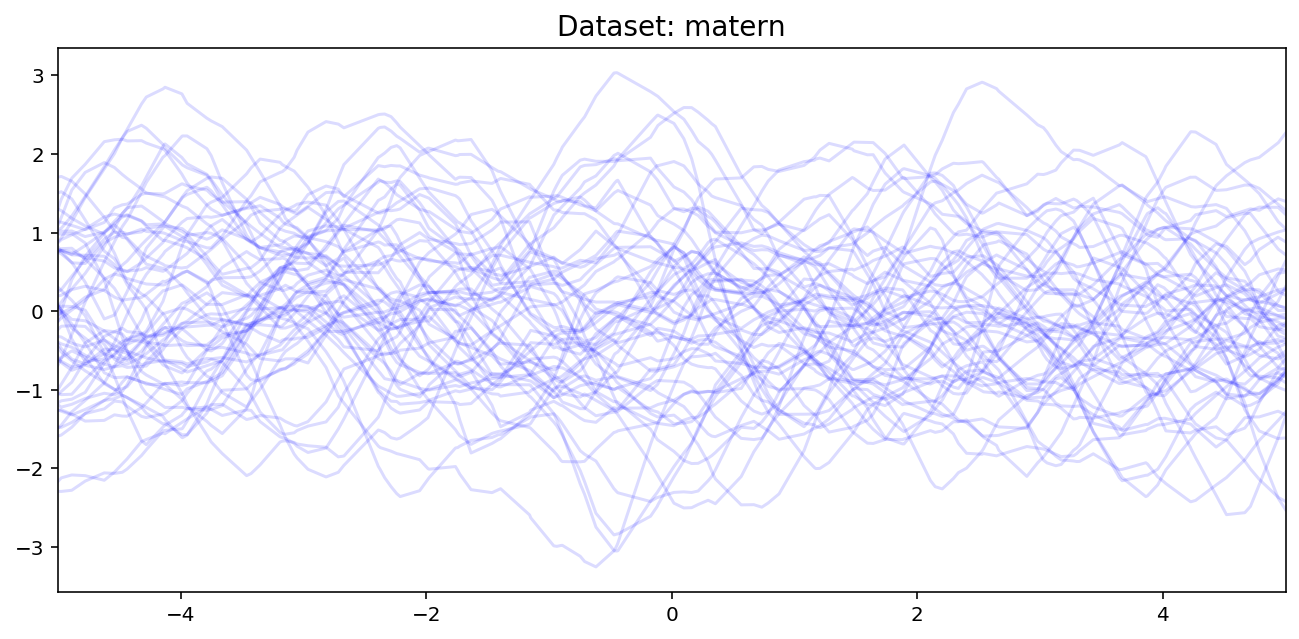

In [6]:
for k, dataset in datasets.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. Refer to [Tutorial 1 - Conditional Neural Process] for an overview main parameters or the docstrings of `NeuralProcess` for all parameters. 

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [7]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, N_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [8]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings)
from skssl.predefined import MLP, add_flat_input, DeepMLP
from skssl.transformers.neuralproc.datasplit import context_target_split

def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def init_model():
    return NeuralProcess(X_DIM, Y_DIM,
                         XEncoder=MLP, # no sinusoidal encodings
                         XYEncoder=add_flat_input(DeepMLP),  # no self attention encoder (3 hidden layer MLP)
                         Decoder=add_flat_input(DeepMLP), # no self attention decoder (3 hidden layer MLP)
                         r_dim=R_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         PredictiveDistribution=Normal, # Gaussian predictive distribution
                         LatentEncoder=MLP,
                         encoded_path="latent") # use NP

# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [9]:
from utils.helpers import count_parameters

for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 186178


### Prior Samples
We can visualize the prior (i.e. the output of the neural process without any context points) before training.

std: 1.199879968762398


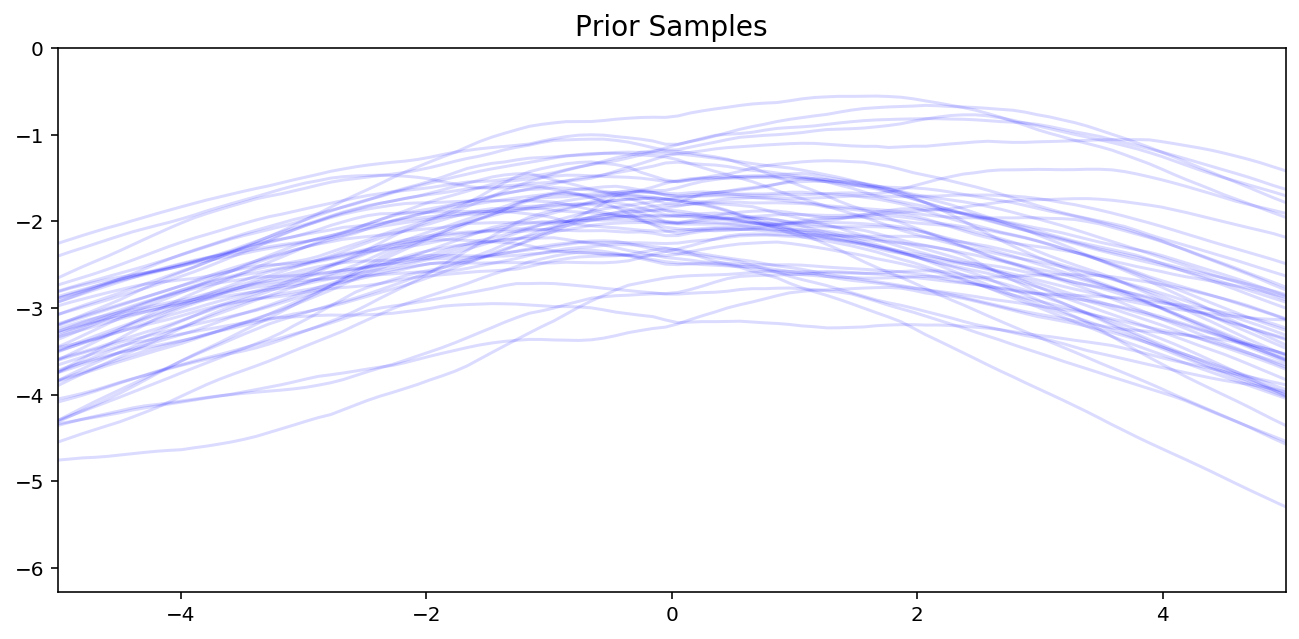

In [10]:
for k, (neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, train_min_max=dataset.min_max)
    # all the models at the start are "similar" so plot only one
    break

# Training

In [11]:
N_EPOCHS = 50
BATCH_SIZE = 64
is_RETRAIN = True # if false load precomputed

In [ ]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/np_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # use smaller lr because latent
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))
    
    # load in all case => even when training loads the best checkpoint
    model.initialize()
    model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      111.1101     +  28.0527


      2       48.1601     +  28.2134


      3       21.0565     +  28.3438


      4        2.7288     +  26.7341


      5      -17.3719     +  27.4129


      6      -32.9701     +  28.2135


      7      -48.8124     +  27.0760


      8      -59.4805     +  27.5333


      9      -73.0803     +  27.8611


     10      -77.0223     +  27.8589


     11      -80.8009     +  28.3768


     12      -84.0465     +  27.9923


     13      -91.3308     +  26.8998


     14      -95.9130     +  27.4552


     15     -101.0109     +  27.6200


     16     -102.3502     +  28.4306


     17     -100.2656        25.9462


     18     -104.0338     +  24.2536


     19     -102.3193        25.7250


     20     -104.7437     +  25.6509


     21     -103.8310        25.1176


     22     -106.2560     +  25.0499


     23     -104.1899        24.8673


     24     -108.0308     +  25.1986


     25     -109.6367     +  25.3315


     26     -113.0518     +  24.9753


     27     -112.8955        25.5835


     28     -111.7105        24.7950


     29     -113.6721     +  25.1082


     30     -114.5276     +  24.7496


     31     -111.8506        25.1098


     32     -111.8696        24.0098


     33     -114.9960     +  25.4466


     34     -112.0661        26.0704


     35     -113.3959        23.0992


     36     -113.1631        24.3865


     37     -115.7214     +  23.1415


     38     -112.3695        23.9401


     39     -114.2452        22.8529


     40     -115.4692        24.3284


     41     -114.6757        21.6528


     42     -112.7691        24.0707


     43     -117.9969     +  25.3894


     44     -116.4810        24.6660


     45     -115.0748        25.3222


     46     -114.4203        25.3561


     47     -117.5617        26.2788


     48     -116.6292        24.9181


     49     -112.8892        20.4831


     50     -116.0582        20.7022

--- Training periodic ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      134.1907     +  24.3578


      2      128.4794     +  20.8879


      3      121.5736     +  25.6076


      4       96.1465     +  25.0067


      5       87.1994     +  25.3763


      6       77.7672     +  25.7127


      7       43.0230     +  25.9379


      8       20.3656     +  25.3229


      9       -5.2471     +  22.6200


     10      -16.0412     +  24.9813


     11      -21.3631     +  25.4401


     12      -38.9775     +  23.9070


     13      -47.8354     +  25.5281


     14      -55.7638     +  25.0323


     15      -61.4662     +  25.1779


     16      -61.7111     +  24.9006


     17      -64.7571     +  24.5704


     18      -65.8563     +  25.3784


     19      -70.0423     +  24.0689


     20      -72.3859     +  23.2267


     21      -85.7152     +  25.1653


     22      -97.0723     +  25.5617


     23      -88.7529        24.7690


     24     -101.4190     +  24.1007


     25     -106.0612     +  23.4969


     26     -111.1966     +  25.4994


     27      -98.5381        23.4976


     28     -102.9639        23.3429


     29     -110.7331        25.0765


     30     -104.9769        25.2700


     31     -100.3162        25.3592


     32     -108.5270        22.4180


     33     -110.8474        25.8056


     34     -105.5243        25.8426


     35     -100.3784        23.2998


     36     -111.3809     +  24.7747


     37     -106.7139        24.3637


     38     -111.2670        24.1127


     39     -112.8470     +  25.1180


     40     -114.4441     +  25.3301


     41     -106.1383        25.9652


     42     -112.4390        25.5859


     43     -118.7489     +  23.4497


     44     -113.1296        23.3802


     45     -113.1658        25.2919


     46     -109.5888        26.6481


     47     -117.2987        26.0188


     48     -108.7148        24.9399


     49     -101.5290        25.3823


     50     -105.6506        23.8911

--- Training non-stationary ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1       44.7828     +  24.5231


      2      -41.1970     +  24.6932


      3      -53.4227     +  22.1379


      4      -58.2045     +  25.7409


      5      -70.2363     +  25.3896


      6      -75.3046     +  22.7704


      7      -75.3532     +  23.0556


      8      -76.9151     +  24.4000


      9      -84.3629     +  25.3115


     10      -89.4538     +  25.4398


     11      -94.3478     +  23.5720


     12      -96.8321     +  25.0880


     13     -101.2678     +  23.0551


     14      -99.4980        21.4384


     15     -103.9342     +  25.8093


     16     -106.7744     +  25.5563


     17     -106.4665        25.3998


     18     -106.8354     +  22.8514


     19     -112.4467     +  22.7047


     20     -106.9217        24.4412


     21     -112.6303     +  24.4638


     22     -116.9867     +  23.9440


     23     -118.4747     +  23.9106


     24     -120.9423     +  25.3505


     25     -121.0267     +  25.5914


     26     -125.0846     +  15.8980


     27     -124.4130        24.7303


     28     -126.1927     +  21.6266


     29     -122.0373        15.5217


     30     -124.8783        21.6472


     31     -123.1078        24.6507


     32     -120.3762        22.7025


     33     -126.2632     +  27.1795


     34     -125.8098        25.5575


     35     -123.1625        19.1484


     36     -128.8460     +  22.2906


     37     -125.1647        20.7931


     38     -127.3826        25.9523


     39     -131.7859     +  26.7641


     40     -135.2400     +  25.3477


     41     -130.2566        21.7174


     42     -129.6461        20.8318


     43     -134.9692        24.1928


# Trained Prior

In [ ]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

In [ ]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

Note that we already see from the unconditioned prior samples, that extrapolation will not work well.

# Posterior

In [ ]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=30,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are not too bad.

**Good**:
- For mattern and RBF kernel uncertainty at extrapolation is very good

**Bad**:
- standard deviation for non-stationary and periodic kernel collapses to the minimum value it can output (i.e. 0.1) => the latent encodes all of the uncertainty.
- it underfits and the mean does not often pass through the context points (and the variance doesn't decrease at those points).